# Week 6: Transfer learning





### Transfer learning

Reference: [Machine Learning Mastery](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)

- Transfer learning is a way to speed up the training process by re-using model weights that were learned using standard computer vision benchmark datasets. 
- Transfer learning uses models trained on a similar problem as a starting point for another related problem e.g.  useful when the input to the model is the same (e.g. images), but the classification problem is different e.g., a model trained to classify penguins vs swans may be applied to a cats vs dogs setting. 
- Transfer learning decreases training time. 

#### Image Recognition using Transfer Learning

- We can access pre-trained models and model weights for transfer learning via the [Keras Application API](https://keras.io/api/applications/)
- These models can be used as the basis for transfer learning in computer viosions applications because:
    - They have been pre-trained to extract generic features from photographs
    - They have state of the art performance
    - They are easily accessible 


#### Data 

- We will use the dogs and cats data that we used in weeks 4 and 5. 
- First, we get the data and save in the local notebook instance. 
- As per weeks 4 and 5, we will unzip the data, format the directories and create a valisdation dataset in the local instance.
- The code below was run on an **ml_p2_xlarge EC2 instance**
- The next 5 cells should be run in the terminal in jupyterlab (notified by a !)

In [ ]:
! unzip dogs-vs-cats.zip
! unzip train.zip

In [ ]:
! cd train 
! mkdir dog cat
! find . -name 'dog.*' -exec mv {} dog \;
! find . -name 'cat.*' -exec mv {} cat \;

In [ ]:
! cd ..

In [ ]:
! mkdir -p val/dog val/cat #make dog and cat directories in val
! ls train/dog | sort -R |tail -5000 | while read file; do mv train/dog/$file val/dog; done
! ls train/cat | sort -R |tail -5000 | while read file; do mv train/cat/$file val/cat; done

In [14]:
import sagemaker #import sagemaker
print(sagemaker.__version__) #print the sagemaker version
sess = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.42.1


In [15]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
import os
import keras
from matplotlib import pyplot
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

#### Using pre-trained VGG16 model 

- The VGG16 model was trained on a ImageNet challenge dataset.
- The input images have a shape 224 x224 pixels.

More details are  https://keras.io/api/applications/

![VGG structure](VGG.png)

- For this example of transfer learning, we will hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that are for image classification. 
    - Note that transfer learning is very flexible in terms of: 
    - which layers we keep 
    - whether we fix the weights of use them as a starting point
- Here, we will loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to make a binary prediction. 
- So, we are using the we may wish to use the VGG16 model layers, and adding and training new layers of the model without updating the weights of the VGG16 layers. This means that the new output layers to learn to interpret the pre-learned features of the VGG16 model.
- It will take approximately 20 minutes to run


#### Step 1: Load the model 
- The first step is to load the model using the Keras API. IN this case we will use the VGG16 model called using the ```VGG16``` function Arguments to consider: 

    1. **include_top**: whether to include the 3 fully-connected layers at the top of the network that are used to make predictions. We won't include one, allowing a new fully connected output layer to be added and trained. 
    2. **input_shape**: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
    3. **weights**: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
    4. **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
    5. **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

- Next, we **define which layers are trainable** - we are going to keep the weights of the VGG16 model untrainable. This is achived by setting  defining the ```trainable``` property as ```False```. 

- We then add the new classification layers. We first flatten the output of the last pooling layer of the VGG16 model, and add fully connected, dense layers. 

- We then compile the new layers but selected a optimiser, a loss function and which metrics to assess performance by. 

#### Step 2: Define plots

The next section of code defines how the results will be plotted - it will generate 2 graphs, one that shows loss and one that shows accuracy. Results on the training data are showed in blue, and results on the validation data are shown in orange. 


### Step 3: Train the model

- The final section of code is to train the model. 
- Before training, we need to prepare the data so it is in the correct format for the VGG16 model. 
    - The model also expects images mean centered - *i.e.* to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input.
    - We can do this using ```ImageDataGenerator``` by setting the “featurewise_center” argument to “True” and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].


Found 15000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Epoch 1/5
235/235 [==============================] - 214s 912ms/step - loss: 5.6754 - acc: 0.6449 - val_loss: 0.5502 - val_acc: 0.9606
Epoch 2/5
235/235 [==============================] - 214s 911ms/step - loss: 0.5395 - acc: 0.9606 - val_loss: 0.3703 - val_acc: 0.9716
Epoch 3/5
235/235 [==============================] - 214s 912ms/step - loss: 0.2132 - acc: 0.9752 - val_loss: 0.0722 - val_acc: 0.9740
Epoch 4/5
235/235 [==============================] - 213s 907ms/step - loss: 0.0440 - acc: 0.9868 - val_loss: 0.0902 - val_acc: 0.9689
Epoch 5/5
235/235 [==============================] - 214s 913ms/step - loss: 0.0167 - acc: 0.9963 - val_loss: 0.0734 - val_acc: 0.9751
> 97.480


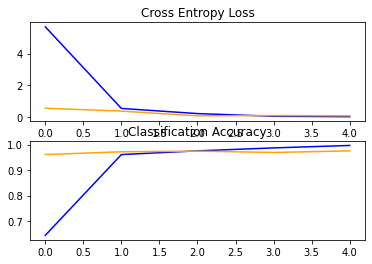

In [16]:

def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')

# Training
# define model
model = define_model()
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train_model = datagen.flow_from_directory('train/',class_mode='binary', batch_size=64, target_size=(224, 224))
test_model = datagen.flow_from_directory('val/',class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = model.fit_generator(train_model, steps_per_epoch=len(train_model),validation_data=test_model, validation_steps=len(test_model), epochs=5, verbose=1)
# evaluate model
_, acc = model.evaluate_generator(test_model, steps=len(test_model), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)


Notice that the accuracy is relatively high for the valuation dataset 97.48%


**Note:** More computations efficient and cost saving to modify the above code into a script, and use SageMaker in Script-mode to train the model. Try this for your **homework**.  

### Train model using built-in CV algorithm for RecordIO files in SageMaker

Similar to last week, except that **use_pretrained_network** is set equal to 1. The final fully connected layer of pretrained RESET model will be reized to the number of classes in the dataset. 

**Note:** Not as flexible but an option if you are less confident. 

In [ ]:
ic.set_hyperparameters(num_layers=18,               # 18 layers
                       use_pretrained_model=1,      # Train from scratch
                       num_classes=2,               # Dogs and cats
                       num_training_samples=22500,  # Number of training samples
                       mini_batch_size=128,
                       epochs=5)  